## Import necessary packages

In [1]:
!nvidia-smi

Sat Aug 22 17:12:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Import pytorch_facenet for the resnet inception model

In [3]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install facenet-pytorch

     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 43.3MB/s 
     |████████████████████████████████| 1.9MB 2.8MB/s 


In [30]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models

import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import shutil
from torchsummary import summary

In [5]:
from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1

## Download, prepare test/val dataset.

### Download LFW dataset and unzip

In [ ]:
LFW_dataset_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz'
# r = requests.get(LFW_dataset_URL, stream=True)
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

--2020-08-22 09:35:34--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  38.3MB/s    in 7.7s    

2020-08-22 09:35:42 (30.3 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [ ]:
!tar zxf lfw-funneled.tgz

Download custom dataset

In [6]:
gdrive_path = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S4_FacialRecognition/'

In [7]:
if not os.path.exists("data"):
    shutil.copy(os.path.join(gdrive_path, "lfw_dataset.zip"), os.getcwd())
    os.mkdir("data")
    !unzip -q lfw_dataset.zip -d data/

In [ ]:
# shutil.rmtree("lfw_funneled")

### Prepare train/val data split for prepared dataset

In [8]:
## No prep required.
data_folder = './data/lfw_dataset'
!ls './data/lfw_dataset/train' | wc

    620     620    9020


### Prepare Train/val split for raw dataset

In [4]:
class_folders = [ f.path for f in os.scandir("lfw_funneled") if f.is_dir() ]

In [5]:
print(len(class_folders))
print(class_folders[:5])

5739
['lfw_funneled/Art_Hoffmann', 'lfw_funneled/Lisa_Marie_Presley', 'lfw_funneled/Imran_Khan', 'lfw_funneled/Mike_Miller', 'lfw_funneled/Almeida_Baptista']


In [6]:
if os.path.exists("data"):
    shutil.rmtree("data")
os.makedirs("data/train")
os.makedirs("data/val")



In [5]:
train_test_split_percentage = 1.0
data_folder = './data'

In [8]:
class_data_size = len(class_folders[:10])
train_data_size = int(np.floor(class_data_size * train_test_split_percentage))
train_folders = class_folders[:train_data_size]
val_folders = class_folders[train_data_size:]

In [9]:
for folder in train_folders:
    shutil.move(folder, os.path.join(data_folder, "train"))

In [ ]:
for folder in val_folders:
    shutil.move(folder, os.path.join(data_folder, "val"))

In [10]:
# Copying train data into val folder to check model
shutil.copytree('./data/train', './data/val')

'./data/val'

In [11]:
ls ./data/val | wc

     10      10     278


## Transform, Datafolder

### Transform

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [36]:
paths_train = glob.glob('./data/lfw_dataset/train/*/*')
paths_test = glob.glob('./data/lfw_dataset/val/*/*')

In [37]:
print(len(paths_train))
print(len(paths_test))

5022
1811


In [10]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)                                 
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [11]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_folder, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

In [12]:
class_names = image_datasets['train'].classes
class_names

['Aaron_Peirsol',
 'Abdoulaye_Wade',
 'Abdullah',
 'Abdullah_Gul',
 'Abel_Pacheco',
 'Adam_Sandler',
 'Adrien_Brody',
 'Ahmed_Chalabi',
 'Ai_Sugiyama',
 'Al_Gore',
 'Al_Sharpton',
 'Alan_Greenspan',
 'Alastair_Campbell',
 'Albert_Costa',
 'Alec_Baldwin',
 'Alejandro_Toledo',
 'Aleksander_Kwasniewski',
 'Alexander_Downer',
 'Alexander_Losyukov',
 'Ali_Naimi',
 'Allyson_Felix',
 'Alvaro_Silva_Calderon',
 'Alvaro_Uribe',
 'Amanda_Bynes',
 'Amelia_Vega',
 'Amelie_Mauresmo',
 'Amer_al-Saadi',
 'Ana_Guevara',
 'Ana_Palacio',
 'Anders_Fogh_Rasmussen',
 'Andre_Agassi',
 'Andy_Roddick',
 'Angela_Bassett',
 'Angela_Merkel',
 'Angelina_Jolie',
 'Angelo_Reyes',
 'Ann_Veneman',
 'Anna_Kournikova',
 'Antonio_Banderas',
 'Antonio_Palocci',
 'Antony_Leung',
 'Ari_Fleischer',
 'Arianna_Huffington',
 'Ariel_Sharon',
 'Arminio_Fraga',
 'Arnold_Schwarzenegger',
 'Arnoldo_Aleman',
 'Art_Howe',
 'Ashanti',
 'Atal_Bihari_Vajpayee',
 'Augustin_Calleri',
 'Ayushmann_Khurrana',
 'Azra_Akin',
 'Barbara_Walters',

In [13]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)

In [14]:
def display_image_class(image_array, label_array, class_names, fig_size = (14, 14)):
    '''
    Displays images along with their class name along a row.
    Input:
        Image_array (tensor array): Denormalized Tensor array of images to be displayed.
        label_array (tensor array): Tensor with class map od images.
        classes (dictionary): Dictionary containing class map and class name.
        fig_size (tuple): display size of each figure

    Output:
        matplot figure. 
    '''
    fig, axs = plt.subplots(1, len(image_array), figsize = fig_size)
    fig.tight_layout()

    for i in range(len(image_array)):
        axs[i].axis("off")
        axs[i].set_title(f'Label: {class_names[label_array[i]]}')
        axs[i].imshow(image_array[i].permute(1,2,0))

In [15]:
inputs, classes = next(iter(dataloaders['train']))
inputs_denormalized = denormalize(inputs[:5], mean, std)

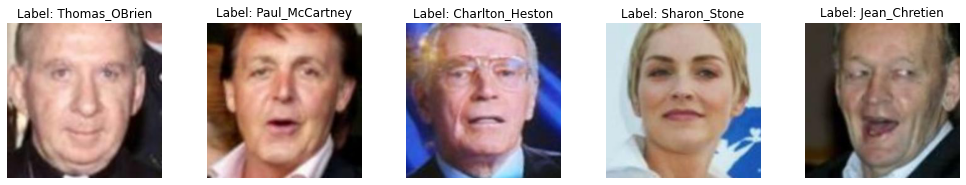

In [16]:
display_image_class(inputs_denormalized, classes[:5], class_names)

### Model setup

In [17]:
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=len(class_names))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('Running on device: {}'.format(device))

Running on device: cuda


In [19]:
model_ft

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

### Freeze early layers

In [20]:
list(model_ft.children())[:6]

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, eps=0.0

In [21]:
layer_list = list(model_ft.children())[-5:] # all final layers

In [22]:
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [23]:
# Keeping all the layers bar the last 5 in nn.Sequential.
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [24]:
# Freeze gradient updation for the top layers.
for param in model_ft.parameters():
    param.requires_grad = False

In [25]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [26]:
# Apply the final layers back into the model.
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
# model_ft.softmax = nn.Softmax(dim=1)

### Model Summary

In [31]:
summary(model_ft, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [27]:
# Move the model to device
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

## Model train

In [28]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()                        
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # Calculated once for train, test for each epoch.
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Scheduler- learning step updated after one epoch train and test
        scheduler.step()
        print(("Epoch-", epoch, "LR rate-", optimizer.param_groups[0]['lr']))
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

## Evaluate

Epoch 0/19
----------
train Loss: 4.0610 Acc: 0.3530
val Loss: 2.1695 Acc: 0.6013
('Epoch-', 0, 'LR rate-', 1)
Epoch 1/19
----------
train Loss: 2.0271 Acc: 0.6362
val Loss: 1.2056 Acc: 0.7874
('Epoch-', 1, 'LR rate-', 1)
Epoch 2/19
----------
train Loss: 1.1503 Acc: 0.8128
val Loss: 0.7543 Acc: 0.8912
('Epoch-', 2, 'LR rate-', 1)
Epoch 3/19
----------
train Loss: 0.6959 Acc: 0.9162
val Loss: 0.5277 Acc: 0.9426
('Epoch-', 3, 'LR rate-', 1)
Epoch 4/19
----------
train Loss: 0.4430 Acc: 0.9592
val Loss: 0.4224 Acc: 0.9586
('Epoch-', 4, 'LR rate-', 1)
Epoch 5/19
----------
train Loss: 0.3107 Acc: 0.9775
val Loss: 0.3674 Acc: 0.9619
('Epoch-', 5, 'LR rate-', 1)
Epoch 6/19
----------
train Loss: 0.2331 Acc: 0.9841
val Loss: 0.3228 Acc: 0.9630
('Epoch-', 6, 'LR rate-', 1)
Epoch 7/19
----------
train Loss: 0.1827 Acc: 0.9888
val Loss: 0.2929 Acc: 0.9702
('Epoch-', 7, 'LR rate-', 1)
Epoch 8/19
----------
train Loss: 0.1530 Acc: 0.9902
val Loss: 0.2809 Acc: 0.9652
('Epoch-', 8, 'LR rate-', 1)
E

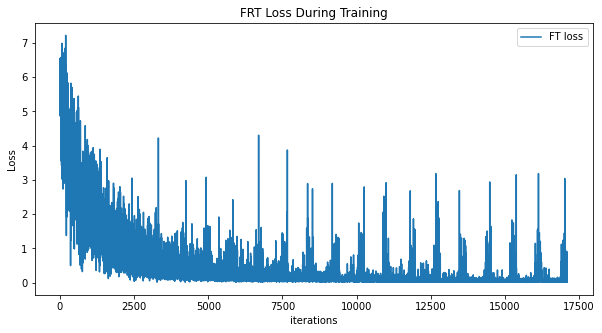

In [29]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Model export

In [44]:
model_ft = model_ft.to(torch.device("cpu"))
model_ft.eval()
traced_model = torch.jit.trace(model_ft, torch.randn(1, 3, 160, 160))
traced_model.save("FaceRecognition_LFW.pt")

In [45]:
shutil.move("FaceRecognition_LFW.pt", os.path.join(gdrive_path, "saved_models"))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S4_FacialRecognition/saved_models/FaceRecognition_LFW.pt'

## Model verification

In [46]:
# from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1
from facenet_pytorch import MTCNN

In [47]:
from PIL import Image
from IPython.display import display

In [48]:
mtcnn = MTCNN(image_size=160, margin=0)
# resnet = InceptionResnetV1(pretrained='vggface2').eval()
# Our trained model
model_ft = model_ft.to(torch.device("cpu"))
model_ft.eval()

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [49]:
## Verification with vggface2 model

img = Image.open("Rohit_Sharma_0005.jpg")

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img)

# Calculate embedding (unsqueeze to add batch dimension)
# img_embedding = resnet(img_cropped.unsqueeze(0))

# Or, if using for VGGFace2 classification
# resnet.classify = True
# img_probs = resnet(img_cropped.unsqueeze(0))

# Our model
img_embedding = model_ft(img_cropped.unsqueeze(0))

model_ft.classify = True
img_probs = model_ft(img_cropped.unsqueeze(0))

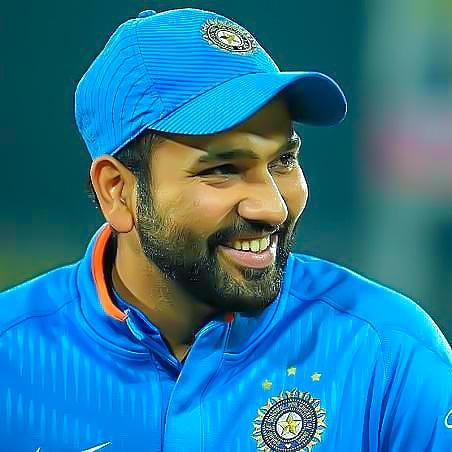

In [50]:
display(img)

In [51]:
print(type(img_cropped))

<class 'torch.Tensor'>


In [56]:
pred = img_probs.argmax(dim=1, keepdim=True).item()
print(pred)
print(class_to_idx[pred])

499
Rohit_Sharma


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


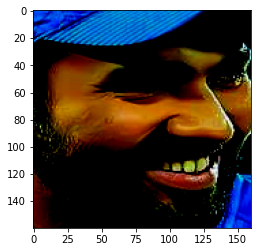

In [57]:
plt.imshow(img_cropped.permute(1,2,0))

In [53]:
def find_classes(dir):
    """
    Finds the class folders in a dataset.

    Args:
    dir (string): Root directory path.

    Returns:
    tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

    Ensures:
    No class is a subdirectory of another.
    """
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {i: cls_name for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [54]:
class_1, class_to_idx = find_classes('./data/lfw_dataset/train')

In [55]:
print(class_to_idx)

{0: 'Aaron_Peirsol', 1: 'Abdoulaye_Wade', 2: 'Abdullah', 3: 'Abdullah_Gul', 4: 'Abel_Pacheco', 5: 'Adam_Sandler', 6: 'Adrien_Brody', 7: 'Ahmed_Chalabi', 8: 'Ai_Sugiyama', 9: 'Al_Gore', 10: 'Al_Sharpton', 11: 'Alan_Greenspan', 12: 'Alastair_Campbell', 13: 'Albert_Costa', 14: 'Alec_Baldwin', 15: 'Alejandro_Toledo', 16: 'Aleksander_Kwasniewski', 17: 'Alexander_Downer', 18: 'Alexander_Losyukov', 19: 'Ali_Naimi', 20: 'Allyson_Felix', 21: 'Alvaro_Silva_Calderon', 22: 'Alvaro_Uribe', 23: 'Amanda_Bynes', 24: 'Amelia_Vega', 25: 'Amelie_Mauresmo', 26: 'Amer_al-Saadi', 27: 'Ana_Guevara', 28: 'Ana_Palacio', 29: 'Anders_Fogh_Rasmussen', 30: 'Andre_Agassi', 31: 'Andy_Roddick', 32: 'Angela_Bassett', 33: 'Angela_Merkel', 34: 'Angelina_Jolie', 35: 'Angelo_Reyes', 36: 'Ann_Veneman', 37: 'Anna_Kournikova', 38: 'Antonio_Banderas', 39: 'Antonio_Palocci', 40: 'Antony_Leung', 41: 'Ari_Fleischer', 42: 'Arianna_Huffington', 43: 'Ariel_Sharon', 44: 'Arminio_Fraga', 45: 'Arnold_Schwarzenegger', 46: 'Arnoldo_Alem

In [38]:
len(FT_losses)

17100